In [1]:
import openmm as mm
import openmm.app as app
import openmm.unit as unit
import numpy as np
from sys import stdout

def calculate_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def calculate_angle(point1, point2, point3):
    vec1 = point1 - point2
    vec2 = point3 - point2
    cosine_angle = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)

# Load the initial structure
ribosome_data = np.loadtxt('ribosome.txt')
ribosome_data *= 0.67

# in nanometers
ribosome_data *= 0.1

element = app.Element(number=500, name='C1', symbol='C1', mass=20)

def create_system(element, POSITIONS, BOXDIM=500.0):
    topology = app.Topology()
    chain = topology.addChain()
    residue = topology.addResidue(name="CG", chain=chain)
    for i, pos in enumerate(POSITIONS):
        topology.addResidue(name="CG", chain=chain)
        topology.addAtom(name=f"C1", element=element, residue=residue)
    
    ATOMS = [i for i in topology.atoms()]
    for i in range(len(ATOMS)):
        for j in range(i + 1, len(ATOMS)):
            topology.addBond(ATOMS[i], ATOMS[j])
    
    positions = np.around(POSITIONS, decimals=3)
    positions = positions * unit.nanometer

    assert(len(positions) == topology.getNumAtoms())
    topology.setPeriodicBoxVectors(np.array([[BOXDIM/2.0,  0.,  0.], [ 0., BOXDIM/2.0,  0.], [ 0.,  0., BOXDIM]]) * unit.nanometers)
    return topology, positions

def add_forcefield(topology, positions):
    system = mm.System()
    system.setDefaultPeriodicBoxVectors(*topology.getPeriodicBoxVectors())
    for atom in topology.atoms():
        system.addParticle(atom.element.mass)
    # harmonic
    ctr = 0
    harmonic_bond_force = mm.HarmonicBondForce()    
    for bond in topology.bonds():        
        first_atom_position = positions[bond.atom1.index]
        second_atom_position = positions[bond.atom2.index]
        d = calculate_distance(first_atom_position, second_atom_position)
        harmonic_bond_force.addBond(bond.atom1.index, bond.atom2.index, d, 100)
        ctr += 1
    system.addForce(harmonic_bond_force)
    return system


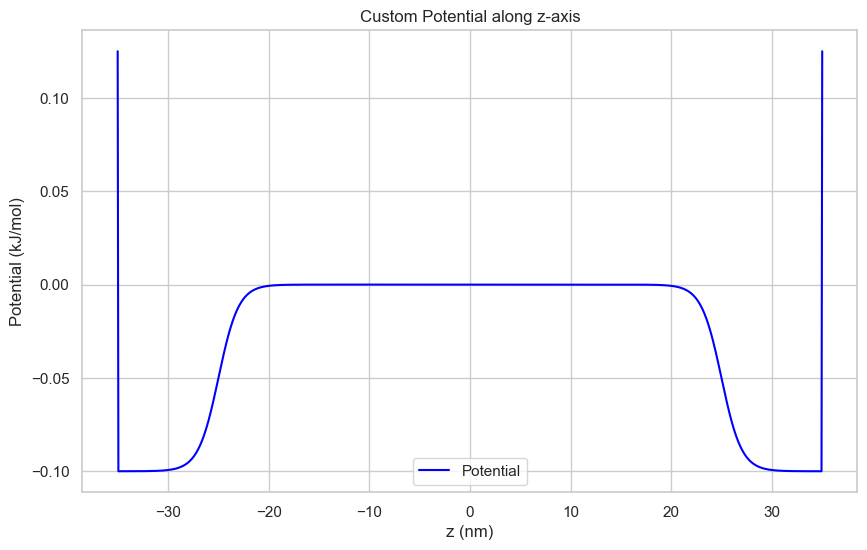

In [1]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Define the potential function
def potential_function(z, z0, r0, k, a):
    periodic_distance = np.abs(z - z0)
    return a * (1.0 / (1 + np.exp(-k * (periodic_distance - r0))) + 1.0 / (1 + np.exp(k * (periodic_distance + r0))))

# Parameters for the potential
z0 = 0.0  # Mean of z-coordinates
r0 = 25.0  # in nanometers
k = 1.0
a = -0.1

# Generate z values for plotting
z_values = np.linspace(-35.015, 35.015, 1000)
potential_values_1 = potential_function(z_values, z0, r0, k, a)

def flat_bottom_potential(z, z0, r0, k):
    distance = np.abs(z - z0)
    return np.where(distance > r0, k * (distance - r0)**2, 0)

# Parameters for the potential
z0 = 0.0  # Reference position
r0 = 35.0  # Flat-bottom radius
k = 1000.0  # Force constant
potential_values_2 = flat_bottom_potential(z_values, z0, r0, k)

# Plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=z_values, y=potential_values_1 + potential_values_2, color="blue", label="Potential")
plt.xlabel("z (nm)")
plt.ylabel("Potential (kJ/mol)")
plt.title("Custom Potential along z-axis")
plt.legend()
plt.show()

In [2]:
TOP, POS = create_system(element, POSITIONS=ribosome_data, BOXDIM=80.0)
SYS = add_forcefield(TOP, POS)

# Define a custom flat bottom potential only along the z-axis with periodic boundary conditions
potential_z = mm.CustomExternalForce("a*(1.0/(1+exp(-k*(periodicdistance(0, 0, z, 0, 0, z0) - r0))) + 1.0/(1+exp(k*(periodicdistance(0, 0, z, 0, 0, z0) + r0))))")

potential_z.addPerParticleParameter("a")
potential_z.addPerParticleParameter("r0")
potential_z.addPerParticleParameter("k")
potential_z.addPerParticleParameter("z0")

# Add the flat bottom potential to each particle
num_particles = len(POS)
for i in range(num_particles):
    potential_z.addParticle(i, [-0.1, 25.0 * unit.nanometer, 1 , np.mean(POS, axis=0)[2]])

SYS.addForce(potential_z)

# Define a custom flat bottom potential only along the z-axis with periodic boundary conditions
flat_bottom_potential_z = mm.CustomExternalForce("step(periodicdistance(0, 0, z, 0, 0, z0) - r0) * k * (periodicdistance(0, 0, z, 0, 0, z0) - r0)^2")
flat_bottom_potential_z.addPerParticleParameter("r0")
flat_bottom_potential_z.addPerParticleParameter("k")
flat_bottom_potential_z.addPerParticleParameter("z0")

# Add the flat bottom potential to each particle
num_particles = len(POS)
for i in range(num_particles):
    flat_bottom_potential_z.addParticle(i, [35.0 * unit.nanometer, 1000.0 * unit.kilojoule / (unit.nanometer**2 * unit.mole), np.mean(POS, axis=0)[2]])

SYS.addForce(flat_bottom_potential_z)



#platform = mm.Platform.getPlatformByName('CUDA')
#properties = {'CudaPrecision':'mixed'}
#integrator = mm.BrownianIntegrator(100 * unit.kelvin, 0.1 / unit.picosecond, 0.005 * unit.picoseconds)
integrator = mm.LangevinIntegrator(1000 * unit.kelvin, 1 / unit.picosecond, 0.010 * unit.picoseconds)
#simulation = app.Simulation(TOP, SYS, integrator, platform, properties)
simulation = app.Simulation(TOP, SYS, integrator)
simulation.context.setPositions(POS)
# Minimize the energy
simulation.minimizeEnergy()

# Save the final frame into a PDB file
positions = simulation.context.getState(getPositions=True).getPositions()
simulation.reporters.append(app.DCDReporter('traj_withfield_0.1.dcd', 5000, enforcePeriodicBox=True))
# Report information to the screen as the simulation runs
simulation.reporters.append(app.StateDataReporter(stdout, 5000, step=True,
        potentialEnergy=True, temperature=True, volume=True, speed=True))
# NVT equilibration
simulation.reporters.append(app.CheckpointReporter('checkpoint.chk', 10000))
simulation.step(500000)

#"Step","Potential Energy (kJ/mole)","Temperature (K)","Box Volume (nm^3)","Speed (ns/day)"
5000,2022.045446395874,1004.7823435936712,128000.0,0
10000,1815.684856414795,1071.5050271363373,128000.0,1.07e+04
15000,2055.03759765625,1135.3074552012536,128000.0,1.06e+04
20000,2151.9104557037354,889.3550152104516,128000.0,1.06e+04
25000,1947.3853664398193,1007.4422897388633,128000.0,1.06e+04
30000,2269.1175231933594,1045.041632070581,128000.0,1.06e+04
35000,2259.171594619751,1075.8876674561086,128000.0,1.06e+04
40000,2112.8508911132812,1080.2003354176773,128000.0,1.06e+04
45000,2153.5537033081055,1045.902944165299,128000.0,1.06e+04
50000,2246.8237915039062,1032.4765929584037,128000.0,1.05e+04
55000,2206.0207023620605,1018.4536778732545,128000.0,1.05e+04
60000,1959.4674854278564,942.8519173902148,128000.0,1.05e+04
65000,2236.574680328369,1024.534003008172,128000.0,1.05e+04
70000,2051.5002632141113,1029.4701081234934,128000.0,1.05e+04
75000,1982.8204078674316,1044.51707881238,128000.0,1.05e+04